<a href="https://colab.research.google.com/github/Monaa48/TensorFlow-in-Action-starter/blob/main/notebooks/Ch06_Teaching_machines_to_see_Image_classification_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 06 — Teaching Machines to See: Image Classification with CNNs

In this chapter, I work with the **Tiny ImageNet** dataset and reproduce the main ideas from the book:
1) do a small exploratory analysis to understand the dataset structure,
2) build data pipelines using Keras `ImageDataGenerator`,
3) implement an **Inception v1–style** CNN (with auxiliary classifiers), and
4) train and evaluate the model.

The goal is not only to get an accuracy number, but also to understand why the model is designed this way (multi-branch Inception blocks, 1×1 convolutions for dimension reduction, and auxiliary outputs to stabilize training).

## 1) Summary

This chapter focuses on **image classification** with convolutional neural networks (CNNs) on a more realistic dataset than MNIST/CIFAR-10.

Key concepts I took from the chapter:
- **Tiny ImageNet** has 200 classes and cluttered real-world images, which makes classification more challenging.
- Instead of loading everything into memory, it is more practical to build an **input pipeline** that streams data in batches.
- The Keras **`ImageDataGenerator`** API can create generators directly from directories or from a DataFrame.
- **Inception blocks** run multiple convolution paths in parallel (1×1, 3×3, 5×5, and pooling), then concatenate the results.
- **1×1 convolutions** are critical for parameter efficiency, because they can reduce the channel dimension before expensive convolutions.
- **Auxiliary outputs** act as additional training signals in deep models, helping gradients reach earlier layers.


## 2) Setup

I start by importing the libraries I need and setting a few global constants.

In [1]:
import os
import random
import zipfile
import urllib.request
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt

SEED = 4321
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


## 3) Download and unpack Tiny ImageNet

The dataset used in the chapter is **Tiny ImageNet-200**. It is commonly distributed as a single zip file, so I download and extract it into a local `data/` folder.

Dataset URL used in the book:
- `http://cs231n.stanford.edu/tiny-imagenet-200.zip`

In [2]:
DATA_ROOT = Path("data")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
zip_path = DATA_ROOT / "tiny-imagenet-200.zip"
extract_dir = DATA_ROOT / "tiny-imagenet-200"

if not zip_path.exists():
    print("Downloading:", url)
    urllib.request.urlretrieve(url, zip_path)
    print("Saved to:", zip_path)

if not extract_dir.exists():
    print("Extracting zip...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(DATA_ROOT)
    print("Extracted to:", extract_dir)
else:
    print("Dataset folder already exists:", extract_dir)

train_dir = extract_dir / "train"
val_dir = extract_dir / "val"
print("Train dir:", train_dir)
print("Val dir  :", val_dir)


Downloading: http://cs231n.stanford.edu/tiny-imagenet-200.zip
Saved to: data/tiny-imagenet-200.zip
Extracting zip...
Extracted to: data/tiny-imagenet-200
Train dir: data/tiny-imagenet-200/train
Val dir  : data/tiny-imagenet-200/val


## 4) Exploratory data analysis

Before training a model, I check the dataset structure and a few simple statistics.

Tiny ImageNet provides:
- `wnids.txt`: the 200 WordNet IDs (class IDs)
- `words.txt`: mapping from WordNet ID → human-readable description
- `train/`: training images organized per class
- `val/`: validation images stored in one folder, with labels in `val_annotations.txt`


### 4.1 Read the class list and class descriptions

In [3]:
wnids_path = extract_dir / "wnids.txt"
words_path = extract_dir / "words.txt"

def get_tiny_imagenet_classes(wnids_path, words_path):
    # wnids.txt has one wnid per line
    wnids = pd.read_csv(wnids_path, header=None)[0].astype(str)

    # words.txt is tab-separated: wnid \t description
    words = pd.read_csv(words_path, sep="\t", index_col=0, header=None)
    words = words[1].astype(str)

    # create a dataframe with wnid + description
    labels = pd.DataFrame({"wnid": wnids})
    labels["class"] = labels["wnid"].map(words)

    return labels

labels = get_tiny_imagenet_classes(wnids_path, words_path)
print("Number of classes:", len(labels))
labels.head(10)


Number of classes: 200


,wnid,class
0,n02124075,Egyptian cat
1,n04067472,reel
2,n04540053,volleyball
3,n04099969,"rocking chair, rocker"
4,n07749582,lemon
5,n01641577,"bullfrog, Rana catesbeiana"
6,n02802426,basketball
7,n09246464,"cliff, drop, drop-off"
8,n07920052,espresso
9,n03970156,"plunger, plumber's helper"


### 4.2 Count training images per class

In [4]:
def get_image_count(images_dir: Path):
    return len([f for f in os.listdir(images_dir) if f.lower().endswith("jpeg")])

labels["n_train"] = labels["wnid"].apply(
    lambda x: get_image_count(train_dir / x / "images")
)

labels["n_train"].describe()


,n_train
count,200.0
mean,500.0
std,0.0
min,500.0
25%,500.0
50%,500.0
75%,500.0
max,500.0


If the dataset is correctly downloaded, every class should have the same number of training images (Tiny ImageNet is class-balanced for train).

### 4.3 Check the image size statistics (a quick sanity check)

In [5]:
image_sizes = []

# check a small subset of classes (first 25) to keep this quick
for wnid in labels["wnid"].iloc[:25]:
    img_dir = train_dir / wnid / "images"
    for f in os.listdir(img_dir):
        if f.endswith("JPEG"):
            image_sizes.append(Image.open(img_dir / f).size)

img_df = pd.DataFrame.from_records(image_sizes, columns=["width", "height"])
img_df.describe()


,width,height
count,12500.0,12500.0
mean,64.0,64.0
std,0.0,0.0
min,64.0,64.0
25%,64.0,64.0
50%,64.0,64.0
75%,64.0,64.0
max,64.0,64.0


### 4.4 Visualize a few sample images

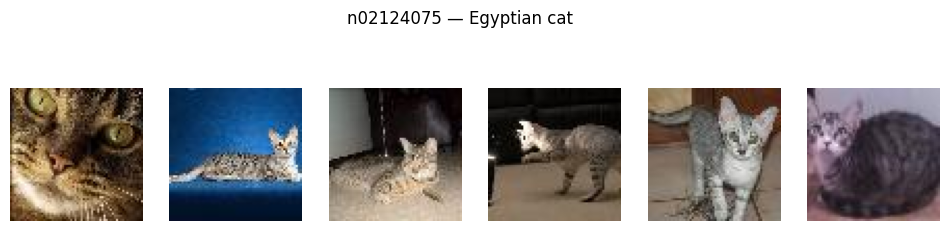

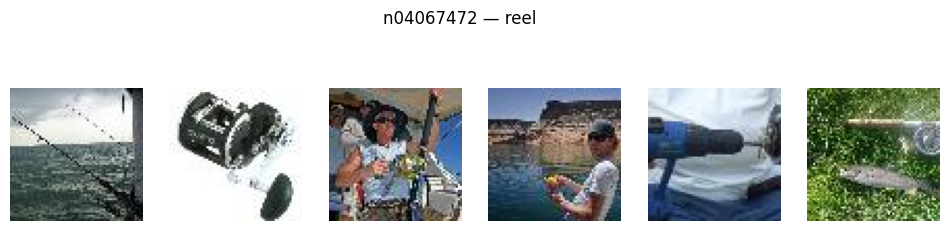

In [6]:
def show_samples_for_wnid(wnid, n=6):
    img_dir = train_dir / wnid / "images"
    files = [f for f in os.listdir(img_dir) if f.endswith("JPEG")]
    files = files[:n]

    desc = labels.loc[labels["wnid"] == wnid, "class"].values[0]
    plt.figure(figsize=(12, 3))
    for i, f in enumerate(files):
        img = Image.open(img_dir / f)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"{wnid} — {desc}")
    plt.show()

# show a couple of classes
for wnid in labels["wnid"].iloc[:2]:
    show_samples_for_wnid(wnid, n=6)


## 5) Data pipelines with `ImageDataGenerator`

In this chapter, the training and validation data come from the training directory, using a `validation_split`. The validation folder is then used as a held-out test set, because it comes with labels in `val_annotations.txt`.

I will create:
- `train_gen`: training batches from `train/` (subset=`training`)
- `valid_gen`: validation batches from `train/` (subset=`validation`)
- `test_gen`: evaluation batches from `val/images` using `flow_from_dataframe`


### 5.1 Create a DataFrame with validation labels

In [7]:
val_annotations_path = val_dir / "val_annotations.txt"

def get_test_labels_df(test_labels_path: Path):
    # val_annotations.txt columns:
    # filename, class (wnid), x, y, w, h
    df = pd.read_csv(test_labels_path, sep="\t", header=None)
    df = df.iloc[:, [0, 1]].rename(columns={0: "filename", 1: "class"})
    return df

test_df = get_test_labels_df(val_annotations_path)
test_df.head()


,filename,class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727
3,val_3.JPEG,n02808440
4,val_4.JPEG,n02808440


### 5.2 Build the generators

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

random_seed = 4321
batch_size = 128
target_size = (56, 56)

image_gen = ImageDataGenerator(samplewise_center=True, validation_split=0.1)

train_gen = image_gen.flow_from_directory(
    directory=str(train_dir),
    target_size=target_size,
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=random_seed,
    subset="training",
)

valid_gen = image_gen.flow_from_directory(
    directory=str(train_dir),
    target_size=target_size,
    classes=None,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=random_seed,
    subset="validation",
)

# Important: keep class order consistent with train_gen
class_list = list(train_gen.class_indices.keys())

test_gen = image_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=str(val_dir / "images"),
    x_col="filename",
    y_col="class",
    target_size=target_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
    classes=class_list,
)

print("train samples:", train_gen.samples)
print("valid samples:", valid_gen.samples)
print("test  samples:", test_gen.samples)


Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
train samples: 90000
valid samples: 10000
test  samples: 10000


### 5.3 Adjust the generator outputs for auxiliary classifiers

The Inception model in this chapter has **three outputs**:
- the main classifier output
- auxiliary output 1
- auxiliary output 2

So the generator needs to return `(x, (y, y, y))` instead of `(x, y)`.

In [9]:
def data_gen_aux(gen):
    for x, y in gen:
        yield x, (y, y, y)

train_gen_aux = data_gen_aux(train_gen)
valid_gen_aux = data_gen_aux(valid_gen)
test_gen_aux = data_gen_aux(test_gen)

# sanity check one batch
x0, (y0a, y0b, y0c) = next(train_gen_aux)
print("x batch:", x0.shape, x0.dtype)
print("y batch:", y0a.shape, y0b.shape, y0c.shape)


x batch: (128, 56, 56, 3) float32
y batch: (128, 200) (128, 200) (128, 200)


## 6) Implementing Inception v1 (adapted for 56×56 inputs)

The model is built from a few reusable parts:
- `stem(...)`: initial conv/pooling layers + local response normalization (LRN)
- `inception(...)`: the multi-branch Inception block
- `aux_out(...)`: an auxiliary classifier head
- `inception_v1()`: puts everything together into a multi-output Keras model


### 6.1 Imports for the model

In [10]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPool2D, AvgPool2D, Dense,
    Flatten, Concatenate, Lambda
)
from tensorflow.keras.models import Model


### 6.2 The stem (early layers + local response normalization)

In [11]:
def stem(inp):
    # A smaller input (56x56) means we need to be careful with early downsampling.
    conv1 = Conv2D(
        64, (7, 7), strides=(1, 1), activation="relu", padding="same"
    )(inp)

    # Downsample once early
    maxpool2 = MaxPool2D((3, 3), strides=(2, 2), padding="same")(conv1)

    # Local Response Normalization (LRN) via a Lambda layer
    lrn3 = Lambda(lambda x: tf.nn.local_response_normalization(x))(maxpool2)

    conv4 = Conv2D(64, (1, 1), strides=(1, 1), activation="relu", padding="same")(lrn3)
    conv5 = Conv2D(192, (3, 3), strides=(1, 1), activation="relu", padding="same")(conv4)

    lrn6 = Lambda(lambda x: tf.nn.local_response_normalization(x))(conv5)

    # Keep stride=1 here so that later blocks still have enough spatial resolution
    maxpool7 = MaxPool2D((3, 3), strides=(1, 1), padding="same")(lrn6)

    return maxpool7


### 6.3 The Inception block

In [12]:
def inception(inp, n_filters):
    # n_filters format:
    # [
    #   (f1x1,),
    #   (f3x3_reduce, f3x3),
    #   (f5x5_reduce, f5x5),
    #   (f_pool_proj,)
    # ]

    # 1x1
    out1 = Conv2D(
        n_filters[0][0], (1, 1), strides=(1, 1),
        activation="relu", padding="same"
    )(inp)

    # 1x1 -> 3x3
    out2_1 = Conv2D(
        n_filters[1][0], (1, 1), strides=(1, 1),
        activation="relu", padding="same"
    )(inp)
    out2_2 = Conv2D(
        n_filters[1][1], (3, 3), strides=(1, 1),
        activation="relu", padding="same"
    )(out2_1)

    # 1x1 -> 5x5
    out3_1 = Conv2D(
        n_filters[2][0], (1, 1), strides=(1, 1),
        activation="relu", padding="same"
    )(inp)
    out3_2 = Conv2D(
        n_filters[2][1], (5, 5), strides=(1, 1),
        activation="relu", padding="same"
    )(out3_1)

    # 3x3 max pool -> 1x1
    out4_1 = MaxPool2D((3, 3), strides=(1, 1), padding="same")(inp)
    out4_2 = Conv2D(
        n_filters[3][0], (1, 1), strides=(1, 1),
        activation="relu", padding="same"
    )(out4_1)

    # concatenate channels
    out = Concatenate(axis=-1)([out1, out2_2, out3_2, out4_2])
    return out


### 6.4 Auxiliary output head

In [13]:
def aux_out(inp, name=None):
    avgpool1 = AvgPool2D((5, 5), strides=(3, 3), padding="valid")(inp)
    conv1 = Conv2D(128, (1, 1), activation="relu", padding="same")(avgpool1)
    flat = Flatten()(conv1)
    dense1 = Dense(1024, activation="relu")(flat)
    aux = Dense(200, activation="softmax", name=name)(dense1)
    return aux


### 6.5 Full Inception v1 model (multi-output)

In [16]:
def inception_v1():
    K.clear_session()

    inp = Input(shape=(56, 56, 3))
    stem_out = stem(inp)

    inc_3a = inception(stem_out, [(64,), (96, 128), (16, 32), (32,)])
    inc_3b = inception(inc_3a, [(128,), (128, 192), (32, 96), (64,)])

    maxpool = MaxPool2D((3, 3), strides=(2, 2), padding="same")(inc_3b)

    inc_4a = inception(maxpool, [(192,), (96, 208), (16, 48), (64,)])
    inc_4b = inception(inc_4a, [(160,), (112, 224), (24, 64), (64,)])

    aux_out1 = aux_out(inc_4a, name="aux1")

    inc_4c = inception(inc_4b, [(128,), (128, 256), (24, 64), (64,)])
    inc_4d = inception(inc_4c, [(112,), (144, 288), (32, 64), (64,)])
    inc_4e = inception(inc_4d, [(256,), (160, 320), (32, 128), (128,)])

    maxpool = MaxPool2D((3, 3), strides=(2, 2), padding="same")(inc_4e)

    aux_out2 = aux_out(inc_4d, name="aux2")

    inc_5a = inception(maxpool, [(256,), (160, 320), (32, 128), (128,)])
    inc_5b = inception(inc_5a, [(384,), (192, 384), (48, 128), (128,)])

    # final pooling and prediction
    avgpool1 = AvgPool2D((7, 7), strides=(1, 1), padding="valid")(inc_5b)
    flat_out = Flatten()(avgpool1)
    out_main = Dense(200, activation="softmax", name="final")(flat_out)

    model = Model(inputs=inp, outputs=[out_main, aux_out1, aux_out2])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "accuracy", "accuracy"])
    return model

model = inception_v1()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 56, 56, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 56, 56,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 28, 28,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 28, 28,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      4,160 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ lambda_1[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]  

 Total params: 10,918,280 (41.65 MB)

 Trainable params: 10,918,280 (41.65 MB)

 Non-trainable params: 0 (0.00 B)

## 7) Training

Because the model has auxiliary outputs, I train it using the wrapped generators (`train_gen_aux`, `valid_gen_aux`).

You can increase `EPOCHS` if you want a stronger final model. I keep it moderate by default so the notebook is runnable in Colab.

In [17]:
EPOCHS = 10

steps_per_epoch = int(np.ceil(train_gen.samples / batch_size))
val_steps = int(np.ceil(valid_gen.samples / batch_size))

history = model.fit(
    train_gen_aux,
    validation_data=valid_gen_aux,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    verbose=1,
)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 339s 404ms/step - aux1_accuracy: 0.0195 - aux1_loss: 5.0782 - aux2_accuracy: 0.0170 - aux2_loss: 5.1091 - final_accuracy: 0.0117 - final_loss: 5.1468 - loss: 15.3341 - val_aux1_accuracy: 0.0792 - val_aux1_loss: 4.3882 - val_aux2_accuracy: 0.0624 - val_aux2_loss: 4.5195 - val_final_accuracy: 0.0480 - val_final_loss: 4.6021 - val_loss: 13.4980
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 252s 358ms/step - aux1_accuracy: 0.1044 - aux1_loss: 4.1941 - aux2_accuracy: 0.0892 - aux2_loss: 4.2970 - final_accuracy: 0.0707 - final_loss: 4.4306 - loss: 12.9218 - val_aux1_accuracy: 0.1478 - val_aux1_loss: 3.8958 - val_aux2_accuracy: 0.1302 - val_aux2_loss: 3.9911 - val_final_accuracy: 0.1072 - val_final_loss: 4.1415 - val_loss: 12.0284
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 252s 358ms/step - aux1_accuracy: 0.1780 - aux1_loss: 3.6864 - aux2_accuracy: 0.1586 - aux2_loss: 3.7963 - final_accuracy: 0.1380 - final_loss: 3.9221 - loss: 11.4047 - val_aux1_accuracy: 0.177

### 7.1 Plot training curves

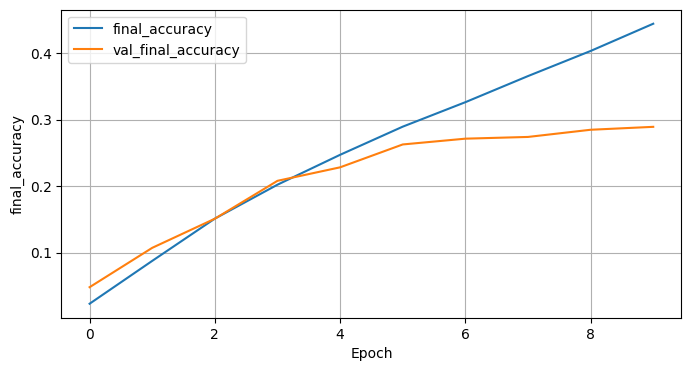

In [18]:
def plot_history(hist, metric="final_accuracy"):
    if metric not in hist.history:
        print("Metric not found:", metric)
        print("Available keys:", list(hist.history.keys())[:20])
        return

    plt.figure(figsize=(8, 4))
    plt.plot(hist.history[metric], label=metric)
    val_key = "val_" + metric
    if val_key in hist.history:
        plt.plot(hist.history[val_key], label=val_key)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

# Keras will name metrics for multi-output models using output layer names.
plot_history(history, metric="final_accuracy")


## 8) Evaluation on the validation (test) set

The validation folder (`val/`) provides labeled images. I evaluate the trained model on this set.

The evaluation returns several values:
- total loss
- loss per output head (`final`, `aux1`, `aux2`)
- accuracy per output head


In [19]:
test_steps = int(np.ceil(test_gen.samples / batch_size))

results = model.evaluate(test_gen_aux, steps=test_steps, verbose=1)
for name, value in zip(model.metrics_names, results):
    print(f"{name:25s}: {value:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - aux1_accuracy: 0.2642 - aux1_loss: 3.4852 - aux2_accuracy: 0.2613 - aux2_loss: 3.5914 - final_accuracy: 0.2977 - final_loss: 3.3195 - loss: 10.3964
loss                     : 10.3635
compile_metrics          : 3.3179
final_loss               : 3.4714
aux1_loss                : 3.5626
aux2_loss                : 0.2658


## 9) Inspect a few predictions

I take a small sample of images from the validation set and compare predicted vs true labels.

In [20]:
# Reverse lookup: index -> wnid
idx_to_wnid = {v: k for k, v in train_gen.class_indices.items()}

# Map wnid -> readable class description (words.txt can have multiple synonyms separated by commas)
wnid_to_desc = dict(zip(labels["wnid"], labels["class"]))

def preprocess_for_model(img_path, target_size=(56, 56)):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    arr = tf.keras.utils.img_to_array(img).astype(np.float32)
    arr = arr - np.mean(arr)  # samplewise_center=True
    return np.expand_dims(arr, axis=0)

def show_prediction_row(df_row):
    img_path = val_dir / "images" / df_row["filename"]
    x = preprocess_for_model(img_path, target_size=target_size)
    pred_main, _, _ = model.predict(x, verbose=0)
    pred_idx = int(np.argmax(pred_main[0]))

    true_wnid = df_row["class"]
    pred_wnid = idx_to_wnid[pred_idx]

    true_desc = wnid_to_desc.get(true_wnid, true_wnid)
    pred_desc = wnid_to_desc.get(pred_wnid, pred_wnid)

    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {true_desc}\nPred: {pred_desc}", fontsize=9)
    plt.show()

# sample a few images
sample_rows = test_df.sample(5, random_state=SEED).reset_index(drop=True)
sample_rows


,filename,class
0,val_7763.JPEG,n03992509
1,val_6764.JPEG,n02281406
2,val_6662.JPEG,n01698640
3,val_5371.JPEG,n01644900
4,val_7257.JPEG,n03404251


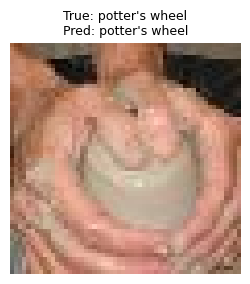

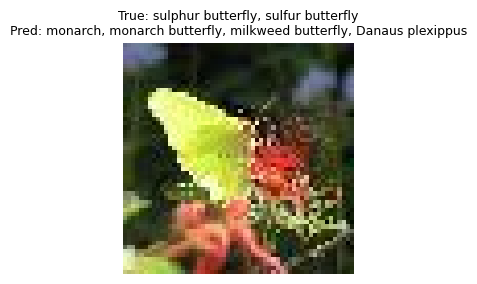

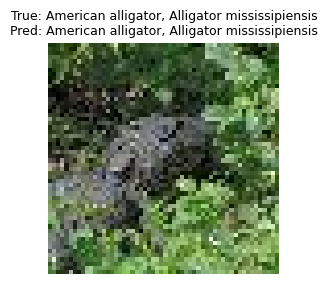

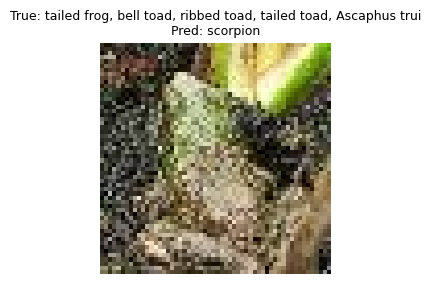

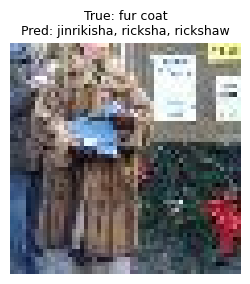

In [21]:
for i in range(len(sample_rows)):
    show_prediction_row(sample_rows.loc[i])


## 10) Takeaways

- Tiny ImageNet is a good example of a dataset where images are **small, noisy, and context-heavy**, so the model must learn robust features.
- `ImageDataGenerator` is convenient for prototyping, especially when the dataset is stored on disk.
- Inception blocks provide a clean way to mix **multiple receptive fields** in the same layer while controlling parameter growth.
- Auxiliary outputs are a practical technique to improve optimization for deep CNNs.
- In the next chapter, improvements like stronger regularization and transfer learning become important to push the results further.